In [30]:
%matplotlib inline
#import sys    
#reload(sys)  
#sys.setdefaultencoding('utf8')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as dates

from __future__ import print_function # for python 2
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import time

from sqlalchemy import create_engine # database connection
import datetime as dt
from IPython.display import display
from IPython.display import clear_output

import scipy.stats
from scipy.signal import savgol_filter

In [2]:
filename="stundenwerte_FF_03811_19830101_20151231_hist.zip"   #ORT: Oschatz historisch

In [6]:
!wget "ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/wind/historical/$filename"

--2016-08-23 21:20:06--  ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/wind/historical/stundenwerte_FF_03811_19830101_20151231_hist.zip
           => »stundenwerte_FF_03811_19830101_20151231_hist.zip.1«
Auflösen des Hostnamen »ftp-cdc.dwd.de (ftp-cdc.dwd.de)«... 141.38.3.177
Verbindungsaufbau zu ftp-cdc.dwd.de (ftp-cdc.dwd.de)|141.38.3.177|:21... verbunden.
Anmelden als anonymous ... Angemeldet!
==> SYST ... fertig.    ==> PWD ... fertig.
==> TYPE I ... fertig.  ==> CWD (1) /pub/CDC/observations_germany/climate/hourly/wind/historical ... fertig.
==> SIZE stundenwerte_FF_03811_19830101_20151231_hist.zip ... 1309217
==> PASV ... fertig.    ==> RETR stundenwerte_FF_03811_19830101_20151231_hist.zip ... fertig.
Länge: 1309217 (1,2M) (unmaßgeblich)

100%[======================================>] 1.309.217   2,14MB/s   in 0,6s   

2016-08-23 21:20:07 (2,14 MB/s) - »stundenwerte_FF_03811_19830101_20151231_hist.zip.1« gespeichert [1309217]



In [3]:
!unzip $filename

Archive:  stundenwerte_FF_03811_19830101_20151231_hist.zip
replace Beschreibung_wind_Element_Detail_03811.html? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
pd.read_csv("Stationsmetadaten_wind_stationen_03811_19830101_20151231.txt",sep=";")

,Stations_id,Stationshoehe,Geogr.Breite,Geogr.Laenge,von_datum,bis_datum,Stationsname,
0,3811,150,51.2959,13.0930,19770301,19771231,Oschatz ...,NaN
1,3811,150,51.2959,13.0930,19780101,20060504,Oschatz ...,NaN
2,3811,150,51.2960,13.0928,20060505,20080731,Oschatz ...,NaN
3,3811,150,51.2960,13.0928,20080801,,Oschatz ...,NaN


In [5]:
dwd_wind=pd.read_csv("produkt_wind_Terminwerte_19830101_20151231_03811.txt",sep=";")
dwd_wind.tail()

/home/noel3/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,WINDGESCHWINDIGKEIT,WINDRICHTUNG,eor
286913,3811,2.015123e+09,7.0,61.0,2.8,220.0,eor
286914,3811,2.015123e+09,7.0,61.0,4.3,220.0,eor
286915,3811,2.015123e+09,7.0,61.0,2.6,230.0,eor
286916,3811,2.015123e+09,7.0,61.0,2.2,220.0,eor
286917,,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
dwd_wind.columns=dwd_wind.columns.str.strip()

In [7]:
dwd_wind = dwd_wind[np.isfinite(dwd_wind['MESS_DATUM'])]
dwd_wind.index=pd.to_datetime(dwd_wind.MESS_DATUM.astype(int), format='%Y%m%d%H')
dwd_wind[dwd_wind.WINDGESCHWINDIGKEIT==-999] =np.NaN

dwd_wind.tail()

,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,WINDGESCHWINDIGKEIT,WINDRICHTUNG,eor
MESS_DATUM,,,,,,,
2015-12-31 19:00:00,3811,2.015123e+09,7.0,61.0,2.5,210.0,eor
2015-12-31 20:00:00,3811,2.015123e+09,7.0,61.0,2.8,220.0,eor
2015-12-31 21:00:00,3811,2.015123e+09,7.0,61.0,4.3,220.0,eor
2015-12-31 22:00:00,3811,2.015123e+09,7.0,61.0,2.6,230.0,eor
2015-12-31 23:00:00,3811,2.015123e+09,7.0,61.0,2.2,220.0,eor


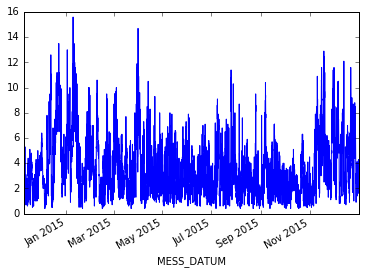

In [8]:
dwd_wind[-10000:].WINDGESCHWINDIGKEIT.plot()

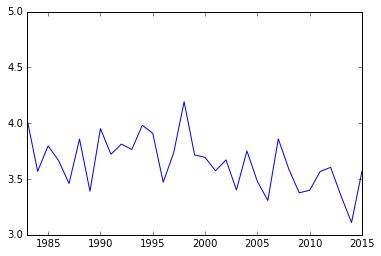

In [9]:
g=dwd_wind.groupby(dwd_wind.index.year)
g.mean()
g.WINDGESCHWINDIGKEIT.mean().plot(ylim=(3,5))

In [10]:
g.WINDGESCHWINDIGKEIT.mean().mean(),"+-",g.WINDGESCHWINDIGKEIT.mean().std()

(3.646266676620438, '+-', 0.23596760360738647)

In [11]:
#(g.WINDGESCHWINDIGKEIT.mean()[0:10].mean()/g.WINDGESCHWINDIGKEIT.mean()[-10:].mean())**3
##23% weniger Windenergie

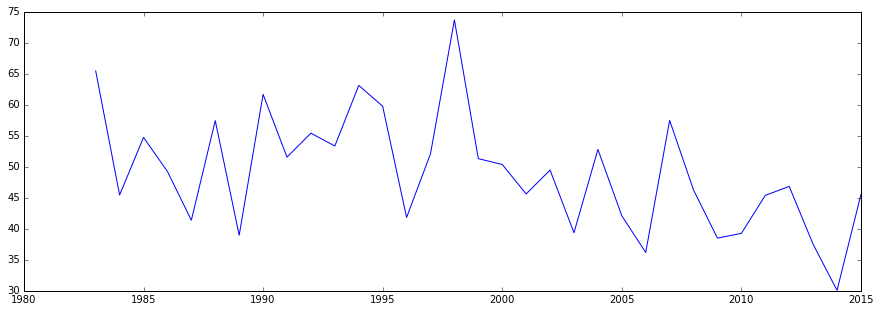

In [12]:
fig=plt.figure(figsize=(15,5))
plt.plot(g.WINDGESCHWINDIGKEIT.mean()**3)

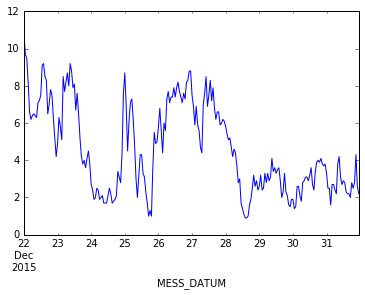

In [13]:
dwd_wind.WINDGESCHWINDIGKEIT[-240:].plot()

In [14]:
filename="stundenwerte_FF_03811_akt.zip" 
!wget "ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/wind/recent/$filename"

--2016-11-06 18:42:04--  ftp://ftp-cdc.dwd.de/pub/CDC/observations_germany/climate/hourly/wind/recent/stundenwerte_FF_03811_akt.zip
           => »stundenwerte_FF_03811_akt.zip.1«
Auflösen des Hostnamen »ftp-cdc.dwd.de (ftp-cdc.dwd.de)«... 141.38.3.177
Verbindungsaufbau zu ftp-cdc.dwd.de (ftp-cdc.dwd.de)|141.38.3.177|:21... verbunden.
Anmelden als anonymous ... Angemeldet!
==> SYST ... fertig.    ==> PWD ... fertig.
==> TYPE I ... fertig.  ==> CWD (1) /pub/CDC/observations_germany/climate/hourly/wind/recent ... fertig.
==> SIZE stundenwerte_FF_03811_akt.zip ... 66177
==> PASV ... fertig.    ==> RETR stundenwerte_FF_03811_akt.zip ... fertig.
Länge: 66177 (65K) (unmaßgeblich)

100%[======================================>] 66.177       279KB/s   in 0,2s   

2016-11-06 18:42:04 (279 KB/s) - »stundenwerte_FF_03811_akt.zip.1« gespeichert [66177]



In [20]:
!unzip $filename

Archive:  stundenwerte_FF_03811_akt.zip
  inflating: Beschreibung_wind_Element_Detail_03811.html  
  inflating: Beschreibung_wind_Geraete_Detail_03811.html  
  inflating: produkt_wind_Terminwerte_20150506_20161105_03811.txt  
  inflating: Stationsmetadaten_wind_stationen_03811_20150506_20161105.txt  


In [15]:
pd.read_csv("Stationsmetadaten_wind_stationen_03811_20150506_20161105.txt",sep=";")

,Stations_id,Stationshoehe,Geogr.Breite,Geogr.Laenge,von_datum,bis_datum,Stationsname,
0,3811,150,51.2959,13.0930,19770301,19771231,Oschatz ...,NaN
1,3811,150,51.2959,13.0930,19780101,20060504,Oschatz ...,NaN
2,3811,150,51.2960,13.0928,20060505,20080731,Oschatz ...,NaN
3,3811,150,51.2960,13.0928,20080801,,Oschatz ...,NaN


In [16]:
akt_wind=pd.read_csv("produkt_wind_Terminwerte_20150506_20161105_03811.txt",sep=";")
akt_wind.head()

,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,WINDGESCHWINDIGKEIT,WINDRICHTUNG,eor
0,3811,2015050600,10,61,2.7,300,eor
1,3811,2015050601,10,61,2.1,300,eor
2,3811,2015050602,10,61,1.4,310,eor
3,3811,2015050603,10,61,1.0,220,eor
4,3811,2015050604,10,61,1.1,240,eor


In [17]:
akt_wind.columns=akt_wind.columns.str.strip()
akt_wind = akt_wind[np.isfinite(akt_wind['MESS_DATUM'])]
akt_wind.index=pd.to_datetime(akt_wind.MESS_DATUM.astype(int), format='%Y%m%d%H')
akt_wind[akt_wind.WINDGESCHWINDIGKEIT==-999] =np.NaN

akt_wind.tail()

,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,WINDGESCHWINDIGKEIT,WINDRICHTUNG,eor
MESS_DATUM,,,,,,,
2016-11-05 19:00:00,3811.0,2.016111e+09,1.0,61.0,1.8,240.0,eor
2016-11-05 20:00:00,3811.0,2.016111e+09,1.0,61.0,3.1,270.0,eor
2016-11-05 21:00:00,3811.0,2.016111e+09,1.0,61.0,3.4,250.0,eor
2016-11-05 22:00:00,3811.0,2.016111e+09,1.0,61.0,3.8,240.0,eor
2016-11-05 23:00:00,3811.0,2.016111e+09,1.0,61.0,3.8,250.0,eor


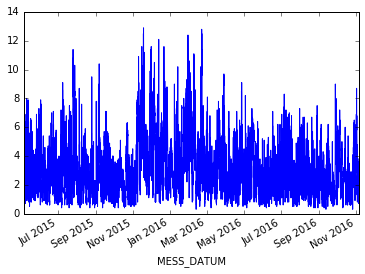

In [18]:
akt_wind.WINDGESCHWINDIGKEIT.plot()

In [19]:
akt_wind.mean()

STATIONS_ID            3.811000e+03
MESS_DATUM             2.015635e+09
QUALITAETS_NIVEAU      7.046914e+00
STRUKTUR_VERSION       6.100000e+01
WINDGESCHWINDIGKEIT    3.187118e+00
WINDRICHTUNG           2.078190e+02
dtype: float64

In [20]:
dwd_wind.mean()

MESS_DATUM             1.999102e+09
QUALITAETS_NIVEAU      9.233790e+00
STRUKTUR_VERSION       3.705777e+01
WINDGESCHWINDIGKEIT    3.645507e+00
WINDRICHTUNG           2.013625e+02
dtype: float64

In [21]:
hist_mean=dwd_wind.mean().WINDGESCHWINDIGKEIT 
hist_mean

3.6455069554094282

In [22]:
akt_mean=akt_wind['2015-11-06':'2016-11-06'].mean().WINDGESCHWINDIGKEIT 
akt_mean

3.3868510928961708

In [23]:
(hist_mean/akt_mean)**3

1.2470546475197877

In [24]:
hist10_mean=dwd_wind['2005-11-06':'2015-11-06'].mean().WINDGESCHWINDIGKEIT
hist10_mean

3.459359935879085

In [25]:
(hist10_mean/akt_mean)**3

1.0656116156209909

/home/noel3/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


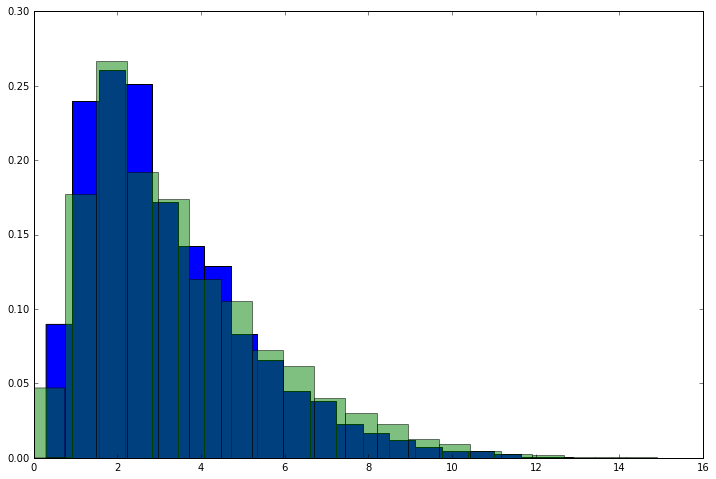

In [26]:
fig=plt.figure(figsize=(12,8))
plt.hist(akt_wind[akt_wind.WINDGESCHWINDIGKEIT<15].WINDGESCHWINDIGKEIT.dropna().values,normed=True, bins=20);
plt.hist(dwd_wind['2005-11-06':'2015-11-06'][dwd_wind.WINDGESCHWINDIGKEIT<15].WINDGESCHWINDIGKEIT.dropna().values,normed=True, bins=20, alpha=.5);

In [27]:
hist10_p=dwd_wind['2006-11-06':'2015-11-06'].WINDGESCHWINDIGKEIT.pow(3)
hist10_p[hist10_p>1000]
akt_p=akt_wind['2015-11-06':'2016-11-06'].WINDGESCHWINDIGKEIT.pow(3) 

In [29]:
hist10_p.mean(),akt_p.mean(),hist10_p.mean()/akt_p.mean()
#14% Weniger Windenergie im letzten Jahr

(106.30416003457789, 93.06954815574079, 1.142201312256191)

In [31]:
disk_engine = create_engine('sqlite:///egneos2.db')

In [118]:
df = pd.read_sql_query('SELECT *'
                       ' FROM Wecstd_Rep limit 720 offset (select count(*) FROM Wecstd_Rep)-17200'
                       , disk_engine)
df.index=pd.DatetimeIndex(df["index"])
df.drop('index', axis=1, inplace=True)
pd.read_sql_query('SELECT Count(*) '
                       'FROM Wecstd_Raw '
                       , disk_engine)

,Count(*)
0,304691


# Daten über 5 Tage

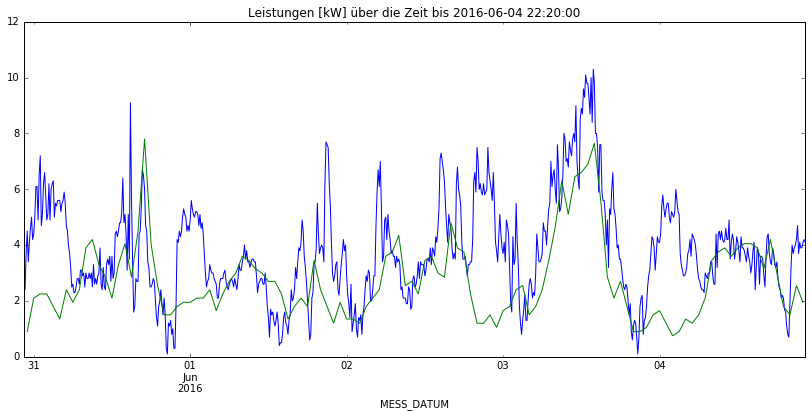

In [119]:
df.MitVwind.plot(rot=45,figsize=(14,6))
akt_wind[df.index.min():df.index.max()].WINDGESCHWINDIGKEIT.multiply(1.5).plot()
plt.title(u'Leistungen [kW] über die Zeit bis '+str(df.index[-1]));


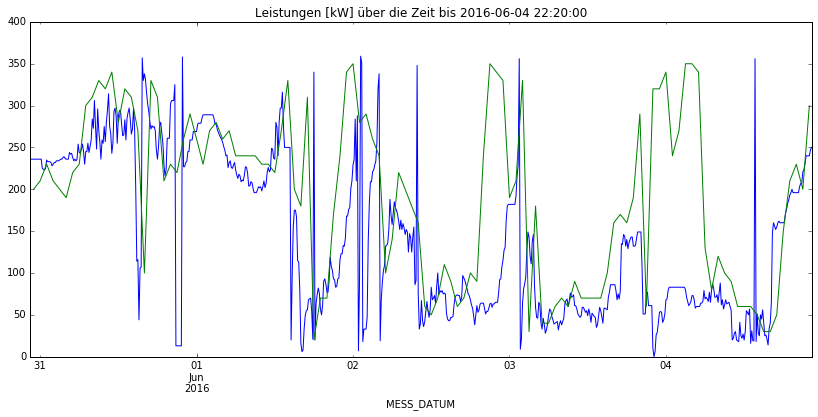

In [120]:
df.GoPos.mod(360).plot(rot=45,figsize=(14,6))
akt_wind[df.index.min():df.index.max()].WINDRICHTUNG.plot()
plt.title(u'Leistungen [kW] über die Zeit bis '+str(df.index[-1]));